## Homework 4: due 2024/05/14 23:59 (100%)

### - Tutorial : 

1. Transfer Learning for Computer Vision Tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor
2. Torchvision transforms: https://pytorch.org/vision/stable/transforms.html
3. Torchvision models: https://pytorch.org/vision/stable/models.html
4. Pytorch learning rate scheduler: https://pytorch.org/docs/stable/optim.html
5. How to get learning rate: https://stackoverflow.com/questions/52660985/pytorch-how-to-get-learning-rate-during-training
6. Pytorch tutorials: https://pytorch.org/tutorials/index.html#

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a multi-class classification model in this part. The data contains the images with three categories: cats, dogs and pandas. You can find the details of each column at https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import time
import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from tqdm import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode

c:\Users\K505\.conda\envs\AI_learn\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
# Define the device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 1. Define the model and dataset (20%)

#### 1.1 Please create the train/validation dataloaders with the data from the __animals__ folder. You can use the function from __torchvision.datasets.ImageFolder__ to load the data. In the training dataset, you should resize the images to 224x224, randomly horizontal flip the images, and normalize the images with mean [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225]. As for the validation dataset, do the same transfromation with the training dataset but without flipping the images.(15%)


##### (Note. The default batch size is 4; however, if your hardware can not afford the computation, you can decrease the batch size.)

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'animals'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

### 1.2 Use the function __imshow__ to show the samples of dataset. (5%)

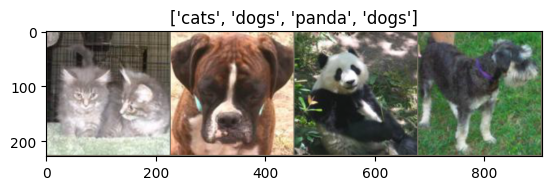

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 2. Train the model (80%)

#### 2.1 Define a function called __train_model__ to train the model and record the loss/accuracy/learning rate/time by adapting the codes from the tutorial. Also, save the model with the best accuracy score on the validation dataset. (15%)


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_name='model'):
    since = time.time()
    train_loss, train_acc, val_loss, val_acc = np.inf, np.inf, np.inf, np.inf
    train_loss_record, train_acc_record, val_loss_record, val_acc_record = list(), list(), list(), list()
    learning_rate_record = list()
    time_record = list()
    # Create a temporary directory to save training checkpoints
    #with TemporaryDirectory() as tempdir:
    model_params_name = model_name + '_best_params.pt'
    best_model_params_path = os.path.join('./model_save/', model_params_name)
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0
    loop = tqdm(range(num_epochs))
    for epoch in loop:
        loop.set_description(f"Epoch {epoch+1}/{num_epochs}")
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            # record the loss and accuracy
            if phase == 'train':
                train_loss, train_acc = epoch_loss, epoch_acc
                train_loss_record.append(train_loss)
                train_acc_record.append(train_acc.item())
            elif phase == 'val':
                val_loss, val_acc = epoch_loss, epoch_acc
                val_loss_record.append(val_loss)
                val_acc_record.append(val_acc.item())
            # record the learning rate
            for param_group in optimizer.param_groups:
                learning_rate_record.append(param_group['lr'])
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        time_record.append(time_elapsed)
        
        loop.set_postfix(
            best_acc=f"{best_acc:.4f}", 
                         train_Loss=f"{train_loss:.4f}", train_Acc=f"{train_acc:.4f}", 
                         val_Loss=f"{val_loss:.4f}", val_Acc=f"{val_acc:.4f}", 
                         time_cost=f"{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
                         )

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, [train_loss_record, train_acc_record, val_loss_record, val_acc_record, learning_rate_record, time_record]

#### 2.2 Please define three models based on ResNet18 to train the networks (1) from scratch (2) by fine-tuning (3) by a fixed feature extractor. The final fully-connected layer(a single linear layer) should be adpted to fulfill this task. (15%)
##### (Note. The ResNet model can be called from the torchvision.model)
##### (Note. The pretrained model should be trained with ImageNet dataset)


In [7]:
num_classes = 3

# Scratch
model_scratch = models.resnet18(weights=None)
num_ftrs = model_scratch.fc.in_features
model_scratch.fc = nn.Linear(num_ftrs, num_classes)
model_scratch = model_scratch.to(device)

# Fine-tuning
model_fine_tuning = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_fine_tuning.fc = nn.Linear(num_ftrs, num_classes)
model_fine_tuning = model_fine_tuning.to(device)

# Fixed feature extractor
model_fixed = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model_fixed.parameters():
        param.requires_grad = False
model_fixed.fc = nn.Linear(num_ftrs, num_classes)
model_fixed = model_fixed.to(device)

#### 2.3 Train three models with the same hyperpameters below and do the validation every epoch. Choose the appropriate type of loss according to the task. Also, use the learning rate scheduler to reduce the learning rate with ratio of 0.1 every 10 epoch. (20%)

#####  (Named the best checkpoints with __resnet_scratch.pth/resnet_finetune.pth/resnet_fixed_extractor.pth__)


| | Learning rate | epochs | optimizer | weight decay | momentum |
|:---:|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 5e-3 | 50 | SGD | 1e-1 | 0.9 |

In [8]:
learning_rate = 5e-3
epoch = 50
weight_decay = 1e-1
momentum = 0.9
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=learning_rate, momentum=momentum)
optimizer_fine_tuning = optim.SGD(model_fine_tuning.parameters(), lr=learning_rate, momentum=momentum)
optimizer_fixed = optim.SGD(model_fixed.parameters(), lr=learning_rate, momentum=momentum)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler_scratch = optim.lr_scheduler.StepLR(optimizer_scratch, step_size=10, gamma=weight_decay)
exp_lr_scheduler_fine_tuning = optim.lr_scheduler.StepLR(optimizer_fine_tuning, step_size=10, gamma=weight_decay)
exp_lr_scheduler_fixed = optim.lr_scheduler.StepLR(optimizer_fixed, step_size=10, gamma=weight_decay)

In [9]:
print('Training model from scratch')
model_scratch, record_scratch = train_model(model_scratch, criterion, optimizer_scratch, exp_lr_scheduler_scratch, num_epochs=epoch, model_name='model_scratch')

print('\nTraining model by fine-tuning')
model_fine_tuning, record_fine_tuning = train_model(model_fine_tuning, criterion, optimizer_fine_tuning, exp_lr_scheduler_fine_tuning, num_epochs=epoch, model_name='model_fine_tuning')

print('\nTraining model by fixed feature extractor')
model_fixed, record_fixed = train_model(model_fixed, criterion, optimizer_fixed, exp_lr_scheduler_fixed, num_epochs=epoch, model_name='model_fixed')

Training model from scratch


Epoch 50/50: 100%|██████████| 50/50 [07:16<00:00,  8.72s/it, best_acc=0.7365, time_cost=7m 16s, train_Acc=0.7228, train_Loss=0.5832, val_Acc=0.7104, val_Loss=0.6119]



Training model by fine-tuning


Epoch 50/50: 100%|██████████| 50/50 [07:12<00:00,  8.65s/it, best_acc=0.7885, time_cost=7m 12s, train_Acc=0.7906, train_Loss=0.4633, val_Acc=0.7792, val_Loss=0.4935]



Training model by fixed feature extractor


Epoch 50/50: 100%|██████████| 50/50 [05:27<00:00,  6.54s/it, best_acc=0.9708, time_cost=5m 27s, train_Acc=0.8594, train_Loss=0.8961, val_Acc=0.9667, val_Loss=0.2054]


#### 2.4 Please draw the plot the learning rate, training/validation loss and training/validation accuracy and compare the performances about three networks. (10%)
##### (Example figure)
![](https://i.imgur.com/LZZTTe6.png)
![](https://i.imgur.com/mUGTWx2.png)
![](https://i.imgur.com/KaNGIDH.png)

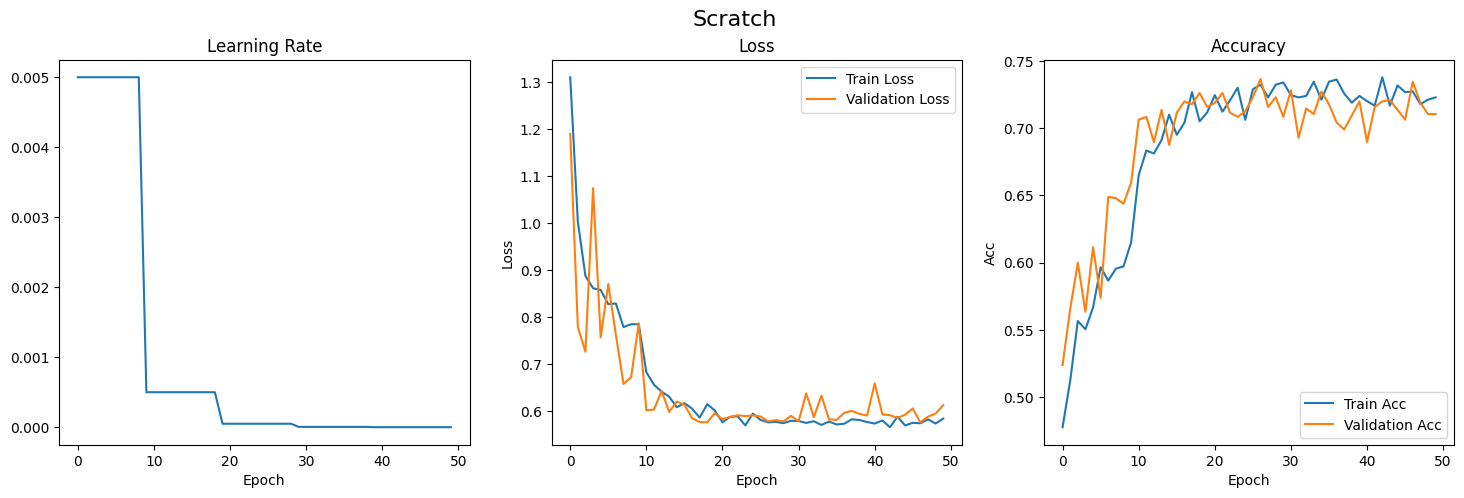

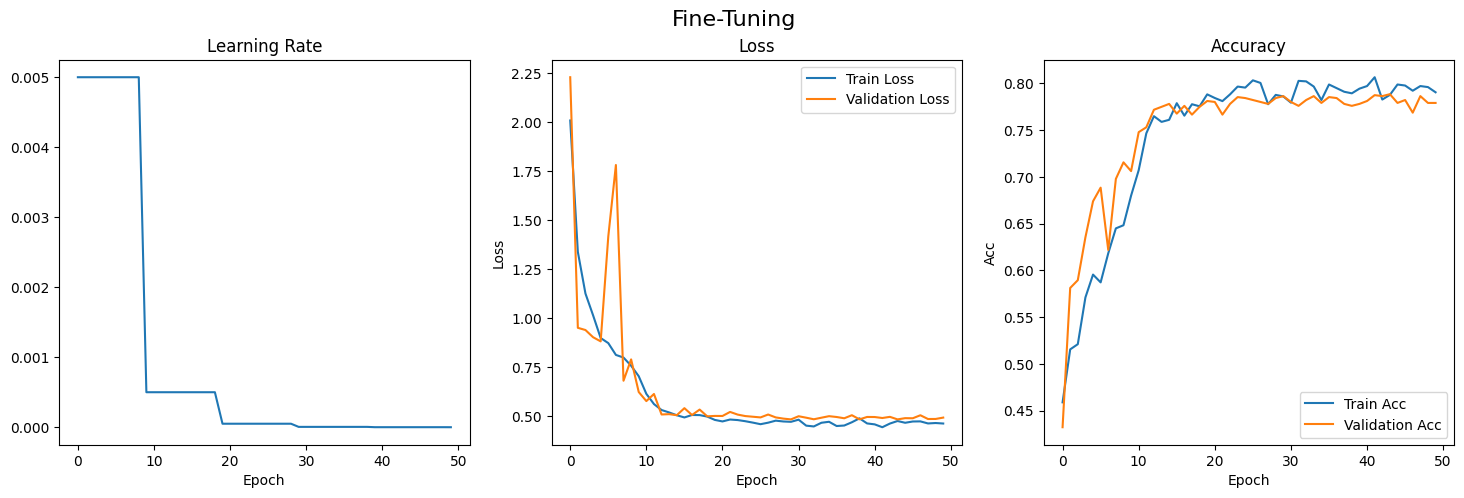

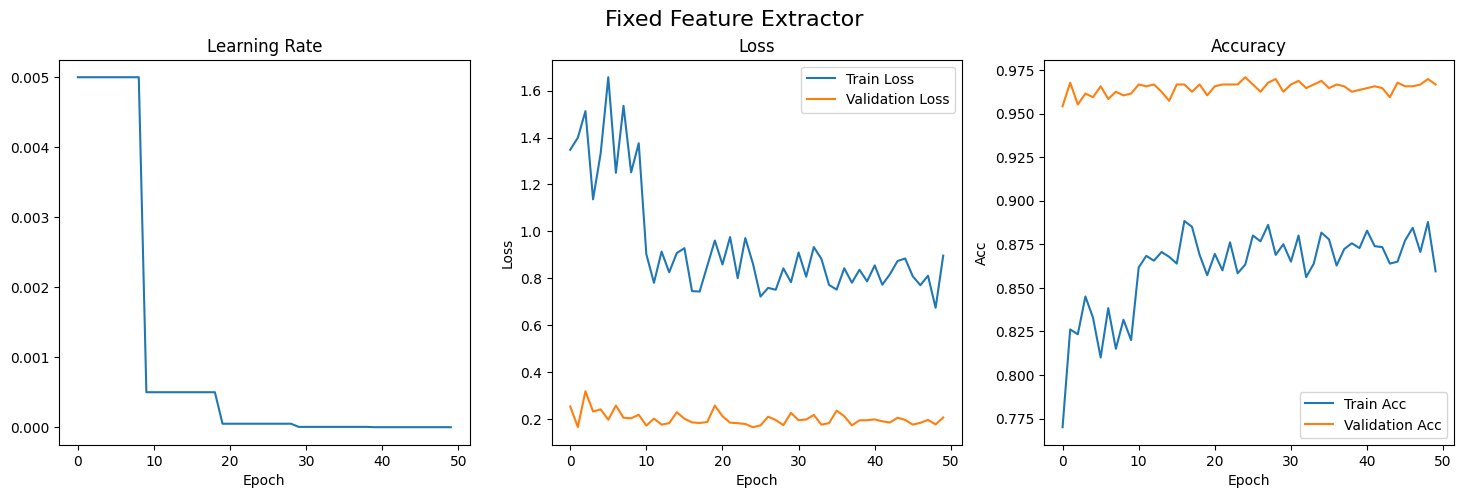

In [10]:
record = [record_scratch, record_fine_tuning, record_fixed]
for i in range(3):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(['Scratch', 'Fine-Tuning', 'Fixed Feature Extractor'][i], fontsize=16)
    loss = list()
    for j in range(len(record[i][4])):
        if j % 2 == 0:
            loss.append(record[i][4][j])
    ax[0].plot(loss)
    ax[0].set_title('Learning Rate')
    ax[1].plot(record[i][0])
    ax[1].plot(record[i][2])
    ax[1].set_title('Loss')
    ax[1].legend(['Train Loss', 'Validation Loss'])
    ax[1].set_ylabel('Loss')
    ax[2].plot(record[i][1])
    ax[2].plot(record[i][3])
    ax[2].set_title('Accuracy')
    ax[2].legend(['Train Acc', 'Validation Acc'])
    ax[2].set_ylabel('Acc')
    for j in range(3):
        ax[j].set_xlabel('Epoch')

#### 2.5 Please calculate the confusion matrix and print the accuracy of three models with the test dataset. (10%)
##### (Example figure)
![](https://i.imgur.com/8U2vl7W.png)

In [11]:
def model_predict(model, img_path):
    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)
    model.eval()
    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
    return class_names[pred]

In [12]:
test_dir = './animals/test/'
model_class = os.listdir(test_dir)
y_true = list()
y_pred_scratch, y_pred_fine_tuning, y_pred_fixed = list(), list(), list()

for i in model_class:
    model_class_dir = os.path.join(test_dir, i)
    model_class_path = os.listdir(model_class_dir)
    for j in model_class_path:
        img_path = os.path.join(test_dir, i, j)
        y_true.append(i)
        y_pred_scratch.append(model_predict(model_scratch, img_path))
        y_pred_fine_tuning.append(model_predict(model_fine_tuning, img_path))
        y_pred_fixed.append(model_predict(model_fixed, img_path))


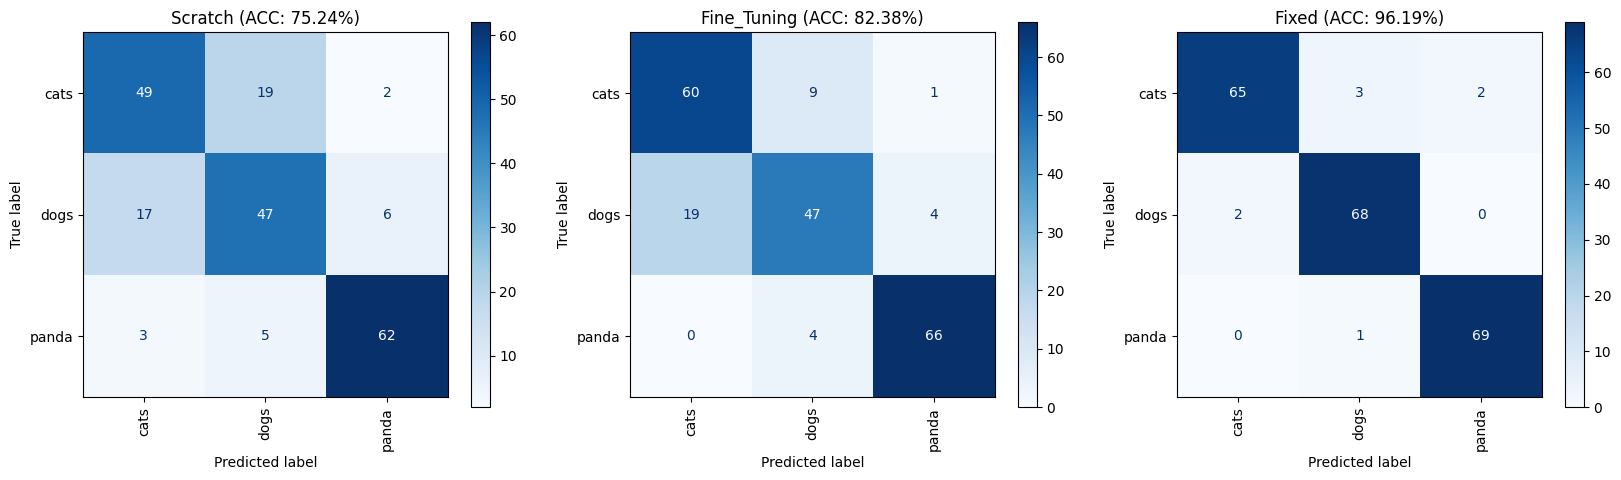

In [13]:
acc_scratch = accuracy_score(y_true, y_pred_scratch)
cm_scratch = confusion_matrix(y_true, y_pred_scratch, labels=model_class)
acc_fine_tuning = accuracy_score(y_true, y_pred_fine_tuning)
cm_fine_tuning = confusion_matrix(y_true, y_pred_fine_tuning, labels=model_class)
acc_fixed = accuracy_score(y_true, y_pred_fixed)
cm_fixed = confusion_matrix(y_true, y_pred_fixed, labels=model_class)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_scratch, display_labels=model_class)
disp.plot(ax=ax[0], xticks_rotation='vertical', cmap='Blues')
ax[0].set_title('Scratch (ACC: {:.2f}%)'.format(acc_scratch*100))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_fine_tuning, display_labels=model_class)
disp.plot(ax=ax[1], xticks_rotation='vertical', cmap='Blues')
ax[1].set_title('Fine_Tuning (ACC: {:.2f}%)'.format(acc_fine_tuning*100))

disp = ConfusionMatrixDisplay(confusion_matrix=cm_fixed, display_labels=model_class)
disp.plot(ax=ax[2], xticks_rotation='vertical', cmap='Blues')
ax[2].set_title('Fixed (ACC: {:.2f}%)'.format(acc_fixed*100))
plt.show()

#### 2.6 Please choose the best model to predict the categories of images in the ***./animals/predict*** folder and show the figure with the prediction as title of each axes. (10%)
##### (Example figure)
![](https://i.imgur.com/Z5v7rET.jpg)

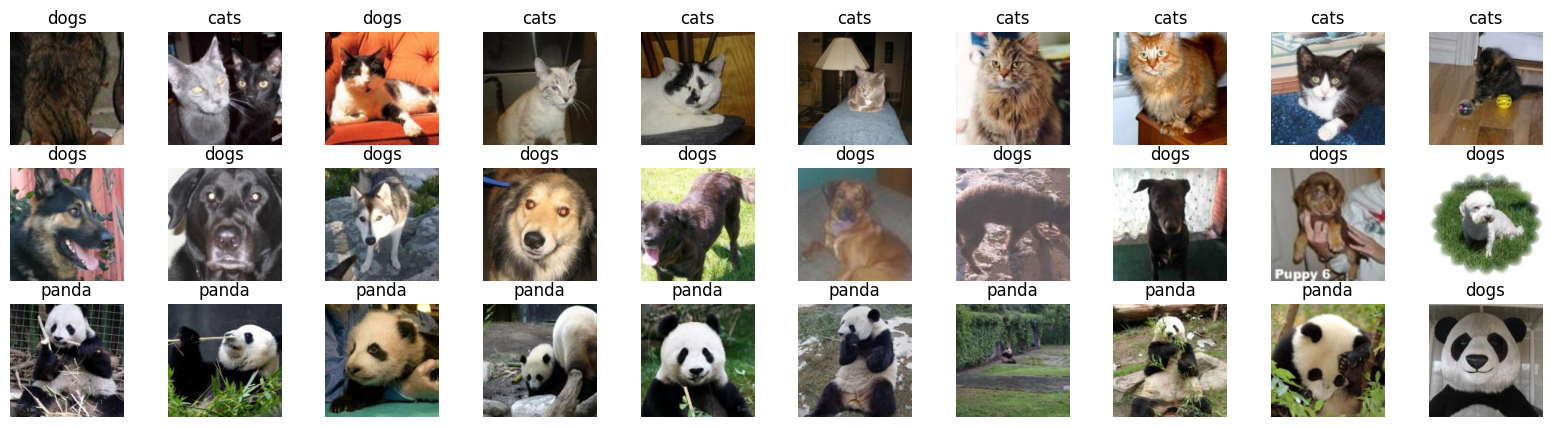

In [14]:
model_fixed.load_state_dict(torch.load("./model_save/model_fixed_best_params.pt"))

test_dir = './animals/prediction/'
prediction_filename = os.listdir(test_dir)
prediction_path = [os.path.join(test_dir, i) for i in prediction_filename]

y_pred = list()

for i in prediction_path:
    y_pred.append(model_predict(model_fixed, i))
    
fig, ax = plt.subplots(3, 10, figsize=(20, 5))
for i in range(len(prediction_path)):
    img = np.array(Image.open(prediction_path[i]))
    ax[i//10, i%10].imshow(img)
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_title(y_pred[i])